# Movie recommendation

Objective: Based on movies list and user ratings estimate how user would rate other movies 

References: 
https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

In [2]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Reshape, Dot, Add, Activation, Lambda, Concatenate, Dropout, Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [3]:
movies = pd.read_csv("data/movies.csv")

In [4]:
ratings = pd.read_csv("data/ratings.csv")

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# Figure out how top 15 users interacts with top 15 movies

In [8]:
top_users = (
    ratings
    .groupby('userId')['rating']
    .count()
    .sort_values(ascending=False)[:15]
)

top_movies = (
    ratings
    .groupby('movieId')['rating']
    .count()
    .sort_values(ascending=False)[:15]
)

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.max)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


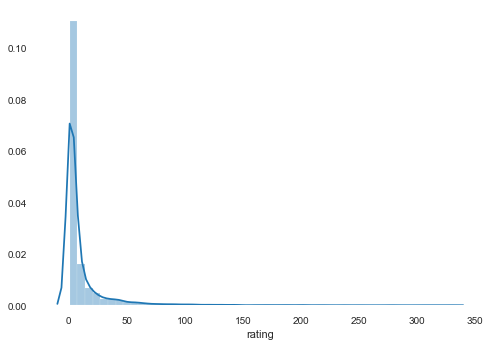

In [9]:
rates_per_user = ratings.groupby('movieId')['rating'].count()
sns.distplot(rates_per_user)

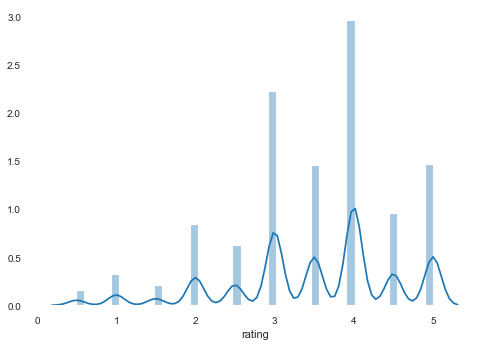

In [10]:
sns.distplot(ratings['rating'])

In [11]:
# encoding

user_enc = LabelEncoder()
movie_enc = LabelEncoder()

ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
ratings['movie'] = movie_enc.fit_transform(ratings['movieId'].values)
ratings['rating'] = ratings['rating'].values.astype(np.float32)

n_users = ratings['user'].nunique()
n_movies = ratings['movie'].nunique()
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

(n_users, n_movies)

(610, 9724)

In [12]:
# Uncomment to print profile report
#profile = ProfileReport(ratings, title='Movies report', html={'style':{'full_width':True}})
#profile

In [13]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

In [14]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]


In [15]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [16]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

In [17]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90752 samples, validate on 10084 samples
Epoch 1/5


/Users/tanis/Development/jupyter/.venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   64/90752 [..............................] - ETA: 15:54 - loss: 11.8956

/Users/tanis/Development/jupyter/.venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


90752/90752 [==============================] - 8s 92us/sample - loss: 9.5977 - val_loss: 3.2672
Epoch 2/5
90752/90752 [==============================] - 6s 67us/sample - loss: 1.9824 - val_loss: 1.6183
Epoch 3/5
90752/90752 [==============================] - 6s 67us/sample - loss: 1.1095 - val_loss: 1.3465
Epoch 4/5
90752/90752 [==============================] - 6s 69us/sample - loss: 0.8545 - val_loss: 1.2650
Epoch 5/5
90752/90752 [==============================] - 6s 68us/sample - loss: 0.7299 - val_loss: 1.2345


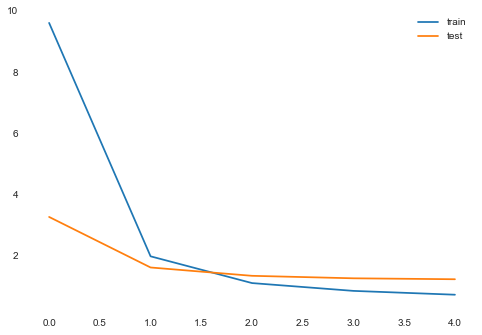

In [18]:
def draw_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend();
    
draw_history(history)    

In [19]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [20]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [21]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

In [22]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90752 samples, validate on 10084 samples
Epoch 1/10


/Users/tanis/Development/jupyter/.venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/tanis/Development/jupyter/.venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


90752/90752 [==============================] - 8s 84us/sample - loss: 0.9349 - val_loss: 0.7941
Epoch 2/10
90752/90752 [==============================] - 7s 73us/sample - loss: 0.7686 - val_loss: 0.7817
Epoch 3/10
90752/90752 [==============================] - 6s 69us/sample - loss: 0.7280 - val_loss: 0.7758
Epoch 4/10
90752/90752 [==============================] - 6s 71us/sample - loss: 0.7098 - val_loss: 0.7818
Epoch 5/10
90752/90752 [==============================] - 7s 74us/sample - loss: 0.6988 - val_loss: 0.7803
Epoch 6/10
90752/90752 [==============================] - 7s 73us/sample - loss: 0.6891 - val_loss: 0.7901
Epoch 7/10
90752/90752 [==============================] - 7s 75us/sample - loss: 0.6837 - val_loss: 0.7949
Epoch 8/10
90752/90752 [==============================] - 7s 73us/sample - loss: 0.6780 - val_loss: 0.7934
Epoch 9/10
90752/90752 [==============================] - 8s 83us/sample - loss: 0.6771 - val_loss: 0.7879
Epoch 10/10
90752/90752 [=======================

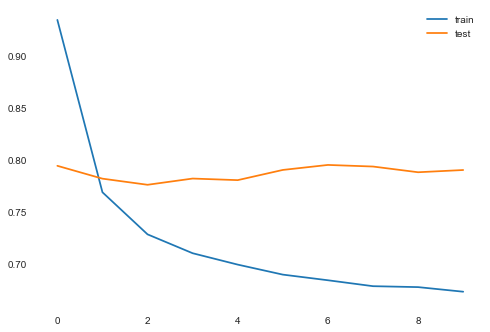

In [23]:
draw_history(history) 

In [24]:
top_r

,userId,movieId,rating,timestamp,rating_r,rating_r
10360,68,1,2.5,1158531426,1260,215
26092,182,1,4.0,1063289621,977,215
36374,249,1,4.0,1347317775,1046,215
39229,274,1,4.0,1171410158,1346,215
42114,288,1,4.5,1054568869,1055,215
...,...,...,...,...,...,...
73936,474,2959,4.0,1100291874,2108,218
93545,599,2959,5.0,1498456882,2478,218
96788,603,2959,4.0,963176105,943,218
97835,606,2959,5.0,1171231517,1115,218


In [35]:
estimated = model.predict(X_test_array)
estimated

array([[2.9204419],
       [3.3298364],
       [2.3808908],
       ...,
       [3.4541008],
       [3.3712783],
       [3.360434 ]], dtype=float32)

In [62]:
esimated_rounded = map(lambda x: round(x * 2) / 2, estimated[:, 0])
expected_actual = pd.DataFrame({'actual':y_test, 'estimated': esimated_rounded})
expected_actual_grouped = expected_actual.groupby(['actual', 'estimated']).size().reset_index(name="size")

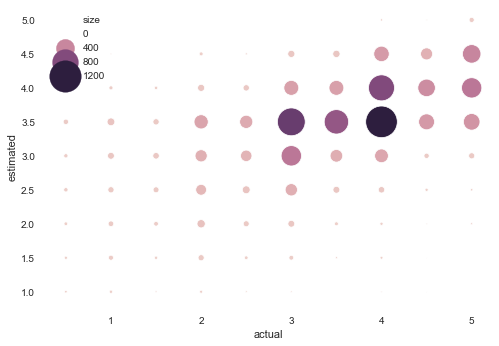

In [63]:
ax = sns.scatterplot(x="actual", y="estimated",
                     hue="size", size="size",
                     sizes=(0, 1000), data=expected_actual_grouped)